In [ ]:
import sklearn
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from tqdm.auto import tqdm

# Part 1.1 - Setup

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
train_data = trainset.data / 255
train_labels = np.array(trainset.targets)
test_data = testset.data / 255
test_labels = np.array(testset.targets)

train_indices = np.random.choice(np.arange(50000), size=5000, replace=False)
test_indices = np.random.choice(np.arange(10000), size=1000, replace=False)

In [ ]:
train_data = train_data[train_indices]
train_labels = train_labels[train_indices]
test_data = test_data[test_indices]
test_labels = test_labels[test_indices]

# Part 1.2 - SVM

In [ ]:
lin_SVM = SVC(kernel='linear')
lin_SVM.fit(train_data.reshape(5000, -1), train_labels)

SVC(kernel='linear')

In [ ]:
lin_pred_labels_test = lin_SVM.predict(test_data.reshape(1000, -1))

In [ ]:
lin_mistakes_test = np.array([int(lin_pred_labels_test[i] == test_labels[i]) for i in range(1000)])
lin_acc_test = np.sum(lin_mistakes_test) / 1000
print(f"Test accuracy of linear SVM: {lin_acc_test}")

Test accuracy of linear SVM: 0.308


In [ ]:
lin_pred_labels_train = lin_SVM.predict(train_data.reshape(5000, -1))
lin_mistakes_train = np.array([int(lin_pred_labels_train[i] == train_labels[i]) for i in range(5000)])
lin_acc_train = np.sum(lin_mistakes_train) / 5000
print(f"Train accuracy of linear SVM: {lin_acc_train}")

In [ ]:
RBF_SVM = SVC(kernel='rbf')
RBF_SVM.fit(train_data.reshape(5000, -1), train_labels)

In [ ]:
rbf_pred_labels_test = RBF_SVM.predict(test_data.reshape(1000, -1))
rbf_mistakes_test = np.array([int(rbf_pred_labels_test[i] == test_labels[i]) for i in range(1000)])
rbf_acc_test = np.sum(rbf_mistakes_test) / 1000
print(f"Test accuracy of RBF SVM: {rbf_acc_test}")

In [ ]:
rbf_pred_labels_train = RBF_SVM.predict(train_data.reshape(5000, -1))
rbf_mistakes_train = np.array([int(rbf_pred_labels_train[i] == train_labels[i]) for i in range(5000)])
rbf_acc_train = np.sum(rbf_mistakes_train) / 5000
print(f"Train accuracy of RBF SVM: {rbf_acc_train}")

In [ ]:
print(train_data.shape)

# Part 2.1 - Baseline model

In [ ]:
B = 64
num_epochs = 20

class BaseLineNN(nn.Module):
    def __init__(self, std, width, xavier_init=False):
        super().__init__()
        
        self.fc1 = nn.Linear(32*32*3, width)
        W1 = torch.normal(0.0, std, size=(32*32*3, width)).type(torch.double)
        W2 = torch.normal(0.0, std, size=(width, 10)).type(torch.double)
        if xavier_init:
          nn.init.xavier_normal_(W1)
          nn.init.xavier_normal_(W2)
        self.fc1.weight = nn.Parameter(W1)
        self.fc2 = nn.Linear(width, 10)
        self.fc2.weight = nn.Parameter(W2)
        
    def forward(self, x):
        x = x @ self.fc1.weight
        x = F.relu(x)
        x = x @ self.fc2.weight
        return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_fn = nn.CrossEntropyLoss()

m_vals = torch.tensor([i/10 for i in range(3,10)])
lr_vals = torch.tensor([i/100 for i in range(1,11)])
std_vals = torch.tensor([0.5, 1.0, 1.5, 2.0])


train_data_flat = torch.from_numpy(train_data.reshape(5000, -1))
test_data_flat = torch.from_numpy(test_data.reshape(1000, -1))

train_labels_cuda = torch.from_numpy(train_labels).to(device)
test_labels_cuda = torch.from_numpy(test_labels).to(device)

test_target_cuda = torch.zeros(1000, 10).to(device)
for i in range(1000):
  test_target_cuda[i][test_labels_cuda[i]] = 1

train_data_flat = train_data_flat.to(device)
test_data_flat = test_data_flat.to(device)

In [ ]:
best_loss = float('inf')
best_hp = (0, 0, 0)

for i in range(len(m_vals)):
  for j in range(len(lr_vals)):
    for k in range(len(std_vals)):
      model = BaseLineNN(std_vals[k], 256)
      model.to(device)
      optimizer = optim.SGD(model.parameters(), lr=lr_vals[j], momentum=m_vals[i])
      for e in range(num_epochs):
        batch_inds = np.random.choice(np.arange(5000), size=B, replace=False)
        batch_inds = torch.from_numpy(batch_inds)
        input = train_data_flat[batch_inds]
        input.type(dtype = torch.double)
        target = torch.zeros(B,10)
        target = target.to(device)
        for s in range(len(batch_inds)):
          target[s][train_labels_cuda[batch_inds[s]]] = 1
        optimizer.zero_grad()
        output = model(input)
        loss = loss_fn(output, target)
        test_pred = model(test_data_flat)
        test_loss = loss_fn(test_pred, test_target_cuda) 
        if test_loss < best_loss:
          best_loss = test_loss
          best_hp = (m_vals[i], lr_vals[j], std_vals[k])
        loss.backward()
        optimizer.step()

KeyboardInterrupt: ignored

In [ ]:
print(f"Best hyperparameters were: momentum={round(float(best_hp[0]), 2)}, lr={round(float(best_hp[1]),2)}, std={best_hp[2]}")

Best hyperparameters were: momentum=0.9, lr=0.09, std=0.5


In [ ]:
def calc_acc(target, pred):
  diff = [target[i] == pred[i] for i in range(len(target))]
  return sum(diff) / len(diff)

In [ ]:
def model_step(model, optimizer, train_loss, test_loss, train_acc, test_acc, idx):
  batch_inds = np.random.choice(np.arange(5000), size=B, replace=False)
  batch_inds = torch.from_numpy(batch_inds)
  input = train_data_flat[batch_inds]
  input.type(dtype = torch.double)
  target = torch.zeros(B,10).to(device)
  # target = target.to(device)
  for s in range(len(batch_inds)):
    target[s][train_labels_cuda[batch_inds[s]]] = 1
  optimizer.zero_grad()
  model.train()
  output = model(input)
  loss = loss_fn(output, target)
  train_loss[idx] += loss.item()
  train_acc[idx] = calc_acc(torch.argmax(output, dim=1), train_labels_cuda[batch_inds])
  loss.backward()
  optimizer.step()
  model.eval()
  test_probs = model(test_data_flat)
  curr_test_loss = loss_fn(test_probs, test_target_cuda) 
  test_pred = torch.argmax(test_probs, dim=1)
  test_acc[idx] = calc_acc(test_pred, test_labels_cuda)
  test_loss[idx] += curr_test_loss.item()

In [ ]:
# now we train a model with the best hyperparameters
best_momentum = 0.9
best_lr = 0.09
best_std = 0.5

num_epochs = 100

test_loss_best_baseline = torch.zeros(num_epochs).to(device)
test_acc_best_baseline = torch.zeros(num_epochs).to(device)
train_loss_best_baseline = torch.zeros(num_epochs).to(device)
train_acc_best_baseline = torch.zeros(num_epochs).to(device)

def test_optimizer(opt_name):
  model = BaseLineNN(best_std, 256)
  model.to(device)
  if opt_name == "sgd":
    optimizer = optim.SGD(model.parameters(), lr=best_lr, momentum=best_momentum)
  else:
    optimizer = optim.Adam(model.parameters(), lr=best_lr)
  for e in tqdm(range(num_epochs)):
    model_step(model, optimizer, train_loss_best_baseline, test_loss_best_baseline, 
               train_acc_best_baseline, test_acc_best_baseline, e)

In [ ]:
test_optimizer("sgd")

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
def plot_acc(test_acc, train_acc, num_epochs):
  plt.plot(range(1,num_epochs+1), test_acc, label = "Test")
  plt.plot(range(1,num_epochs+1), train_acc, label = "Train")
  plt.ylabel("Accuracy")
  plt.xlabel("Epoch")
  plt.title("Accuracy of model over time")
  plt.legend()
  plt.show()

def plot_loss(test_loss, train_loss, num_epochs):
  plt.plot(range(1,num_epochs+1), np.log(test_loss.detach().numpy()), label = "Test")
  plt.plot(range(1,num_epochs+1), np.log(train_loss.detach().numpy()), label = "Train")
  plt.ylabel("Log Loss")
  plt.xlabel("Epoch")
  plt.title("Loss of model over time")
  plt.legend()
  plt.show()

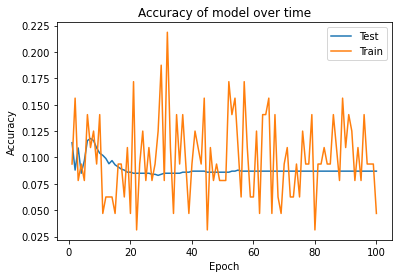

In [ ]:
plot_acc(test_acc_best_baseline, train_acc_best_baseline, num_epochs)

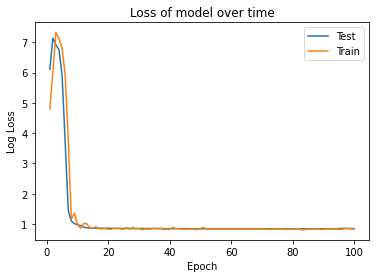

In [ ]:
plot_loss(test_loss_best_baseline, train_loss_best_baseline, num_epochs)

# Part 2.2 - Optimization

In [ ]:
test_optimizer("adam")

  0%|          | 0/100 [00:00<?, ?it/s]

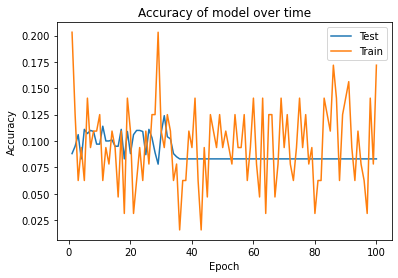

In [ ]:
plot_acc(test_acc_best_baseline, train_acc_best_baseline, num_epochs)

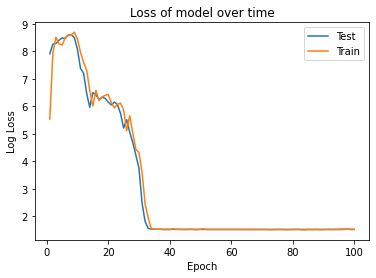

In [ ]:
plot_loss(test_loss_best_baseline, train_loss_best_baseline, num_epochs)

# Part 2.3 - Initialization

Model with Adam optimizer converges a lot quicker, but achieves worse accuracy

In [ ]:
model = BaseLineNN(best_std, 256, xavier_init=True)
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=best_lr, momentum=best_momentum)
for e in tqdm(range(num_epochs)):
  model_step(model, optimizer, train_loss_best_baseline, test_loss_best_baseline, 
              train_acc_best_baseline, test_acc_best_baseline, e)

  0%|          | 0/100 [00:00<?, ?it/s]

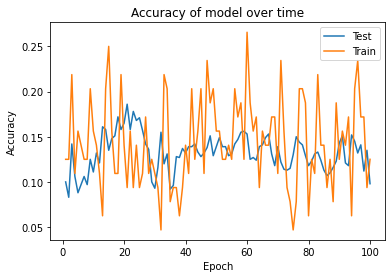

In [ ]:
plot_acc(test_acc_best_baseline, train_acc_best_baseline, num_epochs)

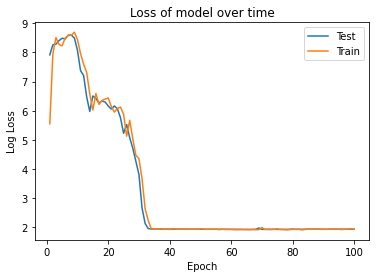

In [ ]:
plot_loss(test_loss_best_baseline, train_loss_best_baseline, num_epochs)

Model achieves better accuracy with xavier initialization, but accuracy drops more over time. Convergance takes more time as well.

# Part 2.4 - Regularization

In [ ]:
decay_vals = [i / 10 for i in range(5,10)]

test_loss_reg = torch.zeros(len(decay_vals), num_epochs).to(device)
test_acc_reg = torch.zeros(len(decay_vals), num_epochs).to(device)
train_loss_reg = torch.zeros(len(decay_vals), num_epochs).to(device)
train_acc_reg = torch.zeros(len(decay_vals), num_epochs).to(device)


for i in tqdm(range(len(decay_vals))):
  model = BaseLineNN(best_std, 256, xavier_init=True)
  model.to(device)
  optimizer = optim.SGD(model.parameters(), lr=best_lr, momentum=best_momentum,
                        weight_decay = decay_vals[i])
  for e in tqdm(range(num_epochs)):
    model_step(model, optimizer, train_loss_reg[i], test_loss_reg[i], 
              train_acc_reg[i], test_acc_reg[i], e)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

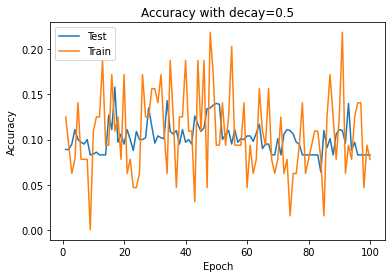

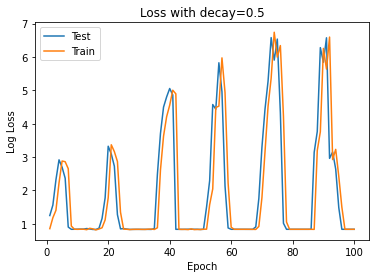

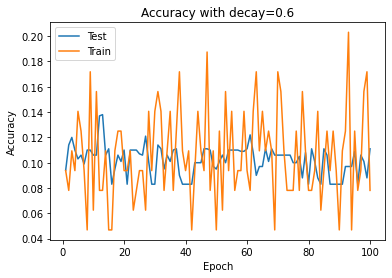

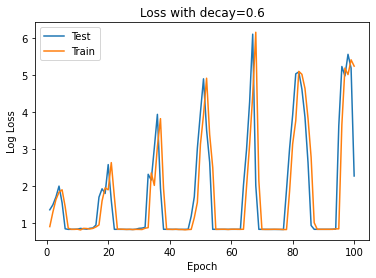

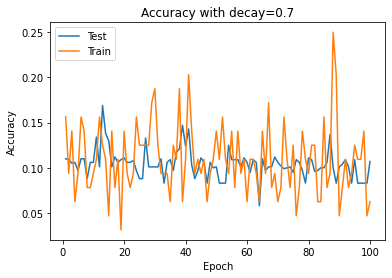

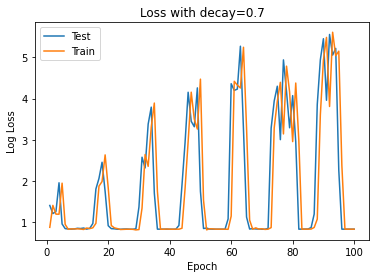

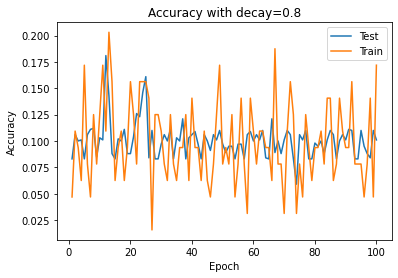

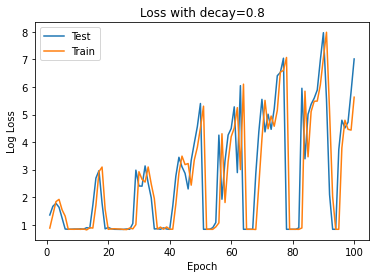

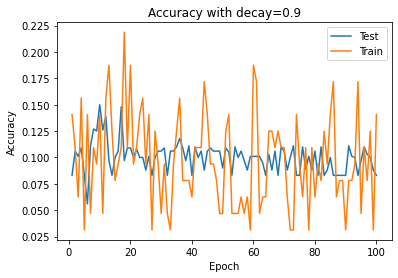

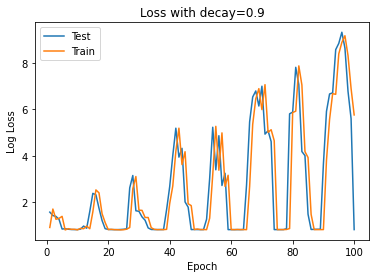

In [ ]:
for i in range(len(decay_vals)):
  plt.plot(range(1,num_epochs+1), test_acc_reg[i], label = "Test")
  plt.plot(range(1,num_epochs+1), train_acc_reg[i], label = "Train")
  plt.ylabel("Accuracy")
  plt.xlabel("Epoch")
  plt.title(f"Accuracy with decay={decay_vals[i]}")
  plt.legend()
  plt.show()

  plt.plot(range(1,num_epochs+1), np.log(test_loss_reg[i].detach().numpy()), label = "Test")
  plt.plot(range(1,num_epochs+1), np.log(train_loss_reg[i].detach().numpy()), label = "Train")
  plt.ylabel("Log Loss")
  plt.xlabel("Epoch")
  plt.title(f"Loss with decay={decay_vals[i]}")
  plt.legend()
  plt.show()

Not sure what's the effect, doesn't seem to change much. Not suprisingly, the more we decay the weights, the more the loss "jumps" from time to time.

In [ ]:
drop_vals = [i/10 for i in range(1,6)]

test_loss_drop = torch.zeros(len(drop_vals), num_epochs).to(device)
test_acc_drop = torch.zeros(len(drop_vals), num_epochs).to(device)
train_loss_drop = torch.zeros(len(drop_vals), num_epochs).to(device)
train_acc_drop = torch.zeros(len(drop_vals), num_epochs).to(device)

class DropNN(BaseLineNN):
    def __init__(self, std, width, p, xavier_init=False):
        super().__init__(std, width)
        
        self.dropout = nn.Dropout(p)
        
    def forward(self, x):
        x = x @ self.fc1.weight
        x = self.dropout(x)
        x = F.relu(x)
        x = x @ self.fc2.weight
        return x

In [ ]:
for i in tqdm(range(len(drop_vals))):
  model = DropNN(best_std, 256, drop_vals[i], xavier_init=True)
  model.to(device)
  optimizer = optim.SGD(model.parameters(), lr=best_lr, momentum=best_momentum)
  for e in tqdm(range(num_epochs)):
    model_step(model, optimizer, train_loss_drop[i], test_loss_drop[i], 
              train_acc_drop[i], test_acc_drop[i], e)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

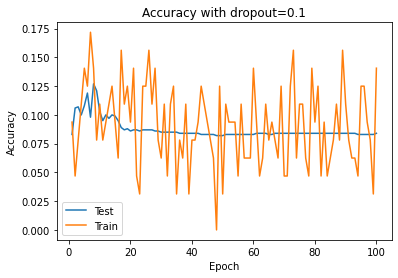

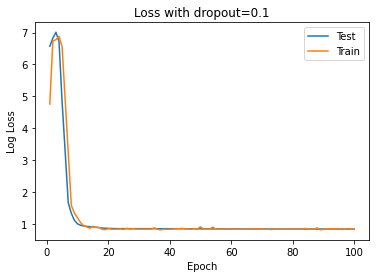

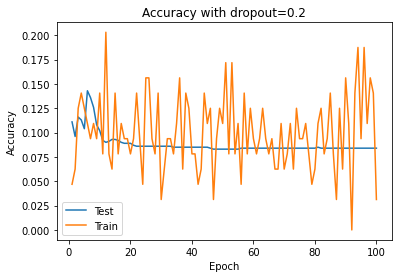

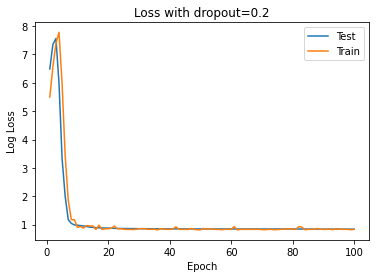

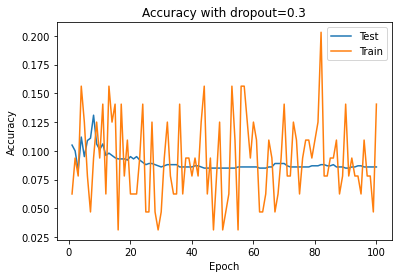

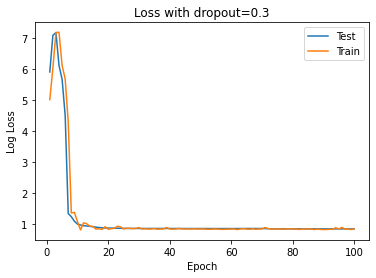

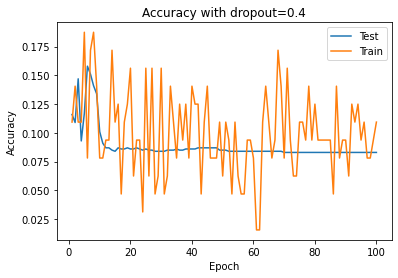

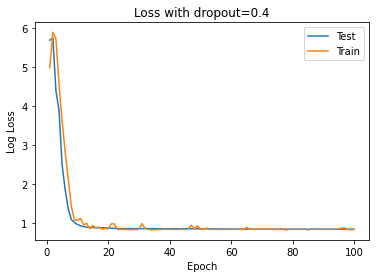

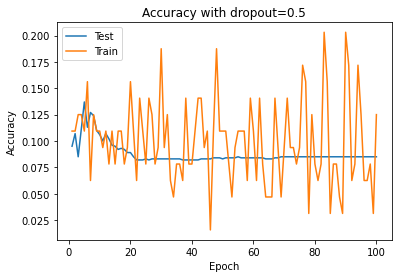

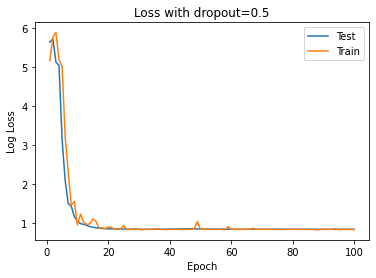

In [ ]:
for i in range(len(drop_vals)):
  plt.plot(range(1,num_epochs+1), test_acc_drop[i], label = "Test")
  plt.plot(range(1,num_epochs+1), train_acc_drop[i], label = "Train")
  plt.ylabel("Accuracy")
  plt.xlabel("Epoch")
  plt.title(f"Accuracy with dropout={drop_vals[i]}")
  plt.legend()
  plt.show()

  plt.plot(range(1,num_epochs+1), np.log(test_loss_drop[i].detach().numpy()), label = "Test")
  plt.plot(range(1,num_epochs+1), np.log(train_loss_drop[i].detach().numpy()), label = "Train")
  plt.ylabel("Log Loss")
  plt.xlabel("Epoch")
  plt.title(f"Loss with dropout={drop_vals[i]}")
  plt.legend()
  plt.show()

Not sure what the effect is.

# Part 2.5 - Preprocessing

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
num_epochs = 100

test_loss_pca = torch.zeros(num_epochs).to(device)
test_acc_pca = torch.zeros(num_epochs).to(device)
train_loss_pca = torch.zeros(num_epochs).to(device)
train_acc_pca = torch.zeros(num_epochs).to(device)

class PCANN(nn.Module):
    def __init__(self, std, width, pca_dim):
        super().__init__()
        
        self.pca = PCA(n_components=pca_dim)
        self.pca.fit(train_data_flat)
        self.fc1 = nn.Linear(pca_dim, width)
        W1 = torch.normal(0.0, std, size=(pca_dim, width)).type(torch.double)
        W2 = torch.normal(0.0, std, size=(width, 10)).type(torch.double)
        self.fc1.weight = nn.Parameter(W1)
        self.fc2 = nn.Linear(width, 10)
        self.fc2.weight = nn.Parameter(W2)
        
    def forward(self, x):
        x = torch.tensor(self.pca.transform(x)).to(device)
        x = x @ self.fc1.weight
        x = F.relu(x)
        x = x @ self.fc2.weight
        return x

In [ ]:
model = PCANN(best_std, 256, 100)
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=best_lr, momentum=best_momentum)
for e in tqdm(range(num_epochs)):
  model_step(model, optimizer, train_loss_pca, test_loss_pca, 
            train_acc_pca, test_acc_pca, e)

  0%|          | 0/100 [00:00<?, ?it/s]

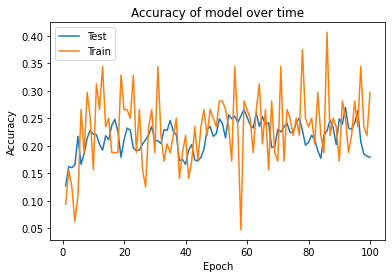

In [ ]:
plot_acc(test_acc_pca, train_acc_pca, num_epochs)

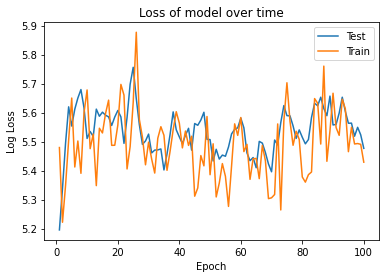

In [ ]:
plot_loss(test_loss_pca, train_loss_pca, num_epochs)

# Part 2.6 - Network Width

In [ ]:
num_epochs = 100
width_vals = [6, 10, 12]

test_loss_wide = torch.zeros(3, num_epochs).to(device)
test_acc_wide = torch.zeros(3, num_epochs).to(device)
train_loss_wide = torch.zeros(3, num_epochs).to(device)
train_acc_wide = torch.zeros(3, num_epochs).to(device)

In [ ]:
for i in tqdm(range(3)):
  model = BaseLineNN(best_std, 2**width_vals[i])
  model.to(device)
  optimizer = optim.SGD(model.parameters(), lr=best_lr, momentum=best_momentum)
  for e in tqdm(range(num_epochs)):
    model_step(model, optimizer, train_loss_wide[i], test_loss_wide[i], 
              train_acc_wide[i], test_acc_wide[i], e)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

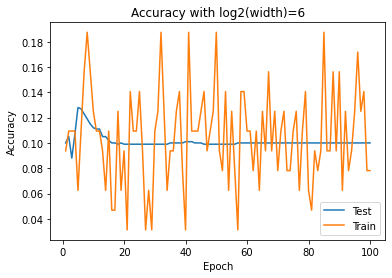

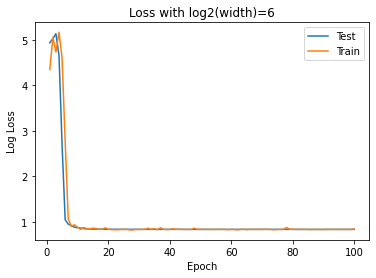

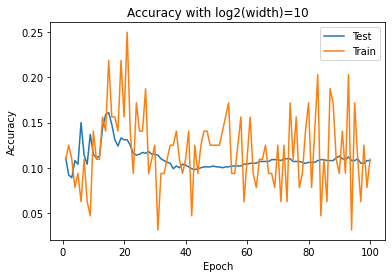

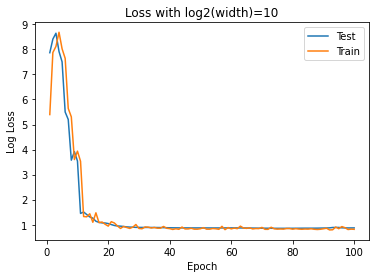

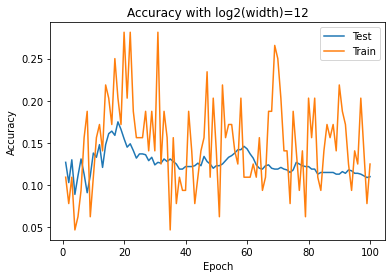

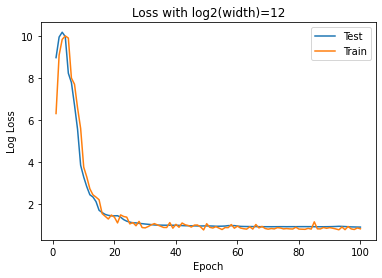

In [ ]:
for i in range(3):
  plt.plot(range(1,num_epochs+1), test_acc_wide[i].cpu(), label = "Test")
  plt.plot(range(1,num_epochs+1), train_acc_wide[i].cpu(), label = "Train")
  plt.ylabel("Accuracy")
  plt.xlabel("Epoch")
  plt.title(f"Accuracy with log2(width)={width_vals[i]}")
  plt.legend()
  plt.show()

  plt.plot(range(1,num_epochs+1), np.log(test_loss_wide[i].detach().cpu().numpy()), label = "Test")
  plt.plot(range(1,num_epochs+1), np.log(train_loss_wide[i].detach().cpu().numpy()), label = "Train")
  plt.ylabel("Log Loss")
  plt.xlabel("Epoch")
  plt.title(f"Loss with log2(width)={width_vals[i]}")
  plt.legend()
  plt.show()

The wider we set the NN, the more expressive it becomes, therefore able to achieve higher accuracy on the test and train sets.

# Part 2.7 - Network Depth

In [ ]:
class DeepNN(nn.Module):
    def __init__(self, std, width, depth):
        super().__init__()
        self.depth = depth-1
        self.layers = nn.ModuleList()

        self.layers.append(nn.Linear(32*32*3, width))
        W = torch.normal(0.0, std, size=(32*32*3, width)).type(torch.double)
        self.layers[0].weight = nn.Parameter(W)

        for i in range(1, self.depth-1):
          self.layers.append(nn.Linear(width, width))
          W = torch.normal(0.0, std, size=(width, width)).type(torch.double)
          self.layers[i].weight = nn.Parameter(W)
        
        self.layers.append(nn.Linear(width, 10))
        W = torch.normal(0.0, std, size=(width, 10)).type(torch.double)
        self.layers[-1].weight = nn.Parameter(W)
        
    def forward(self, x):
        for i in range(self.depth-1):
          x = x @ self.layers[i].weight
          x = F.relu(x)

        x = x @ self.layers[self.depth-1].weight
        return x

In [ ]:
num_epochs = 100
depth_vals = [3, 4, 10]

test_loss_deep = torch.zeros(3, num_epochs).to(device)
test_acc_deep = torch.zeros(3, num_epochs).to(device)
train_loss_deep = torch.zeros(3, num_epochs).to(device)
train_acc_deep = torch.zeros(3, num_epochs).to(device)

In [ ]:
for i in tqdm(range(3)):
  model = DeepNN(best_std, 64, depth_vals[i])
  model.to(device)
  optimizer = optim.SGD(model.parameters(), lr=best_lr, momentum=best_momentum)
  for e in tqdm(range(num_epochs)):
    model_step(model, optimizer, train_loss_deep[i], test_loss_deep[i], 
              train_acc_deep[i], test_acc_deep[i], e)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

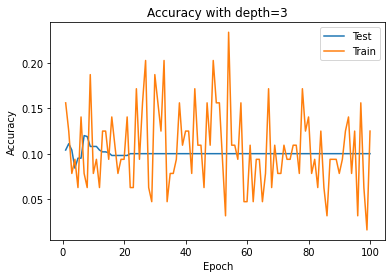

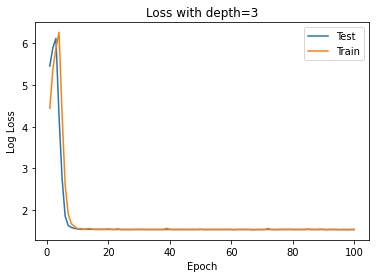

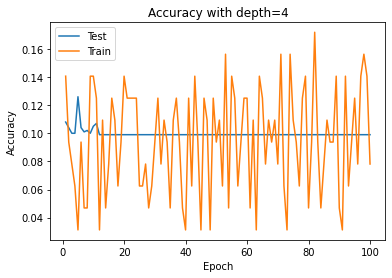

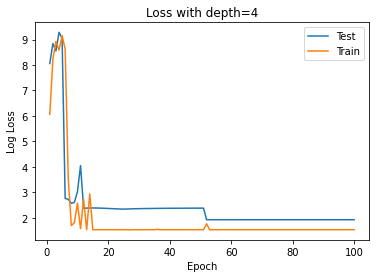

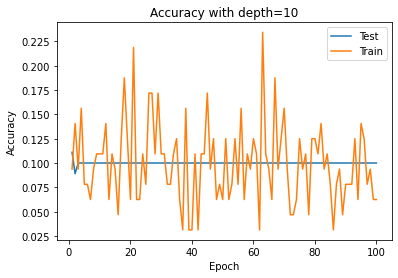

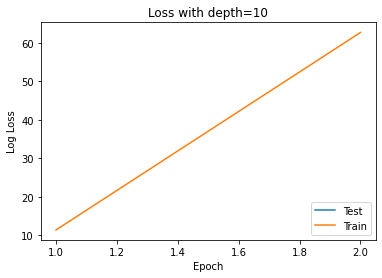

In [ ]:
for i in range(3):
  plt.plot(range(1,num_epochs+1), test_acc_deep[i].cpu(), label = "Test")
  plt.plot(range(1,num_epochs+1), train_acc_deep[i].cpu(), label = "Train")
  plt.ylabel("Accuracy")
  plt.xlabel("Epoch")
  plt.title(f"Accuracy with depth={depth_vals[i]}")
  plt.legend()
  plt.show()

  plt.plot(range(1,num_epochs+1), np.log(test_loss_deep[i].detach().cpu().numpy()), label = "Test")
  plt.plot(range(1,num_epochs+1), np.log(train_loss_deep[i].detach().cpu().numpy()), label = "Train")
  plt.ylabel("Log Loss")
  plt.xlabel("Epoch")
  plt.title(f"Loss with depth={depth_vals[i]}")
  plt.legend()
  plt.show()

Depth doesn't seem to help much with limited width. Test accuracy stays at around 0.1 for all depths, while loss increases with depth, the deepest network's loss actualy increases monotonicly over epochs. It's possible this is due to overfitting.